In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import EarlyStopping

import math

sns.set()
random_state = 123_456
# random_state = 0
np.random.seed(random_state)

Using TensorFlow backend.


In [2]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2017-01-01 to 2019-12-31
Freq: D
Data columns (total 10 columns):
price                          1095 non-null int32
tapis_oil_price_t_minus_10     1095 non-null int64
national_avg_price             1095 non-null int32
sgd_exchange_rate_t_minus_6    1095 non-null float64
usd_exchange_rate              1095 non-null float64
volume_in_ml                   1095 non-null float64
wholesale_price_t_minus_4      1095 non-null int64
wholesale_cluster_label        1095 non-null int64
tapis_oil_cluster_label        1095 non-null int64
price_t_plus_1                 1095 non-null int64
dtypes: float64(3), int32(2), int64(5)
memory usage: 85.5 KB


In [4]:
non_categorical_features = ['price','tapis_oil_price_t_minus_10','wholesale_price_t_minus_4']

In [5]:
# these features slightly decrease the accuracy
# del df['sgd_exchange_rate_t_minus_6']
del df['usd_exchange_rate']
del df['volume_in_ml']
del df['national_avg_price']
del df['wholesale_cluster_label']
del df['tapis_oil_cluster_label']

In [6]:
df

price  tapis_oil_price_t_minus_10  sgd_exchange_rate_t_minus_6  \
2017-01-01   1417                        5863                       1.0425   
2017-01-02   1436                        5863                       1.0425   
2017-01-03   1409                        5863                       1.0425   
2017-01-04   1542                        5863                       1.0425   
2017-01-05   1582                        5863                       1.0425   
...           ...                         ...                          ...   
2019-12-27   1608                        7084                       0.9386   
2019-12-28   1589                        7103                       0.9386   
2019-12-29   1579                        7159                       0.9386   
2019-12-30   1602                        7198                       0.9382   
2019-12-31   1609                        7177                       0.9377   

            wholesale_price_t_minus_4  price_t_plus_1  
2017-01-01                       1183            1436  
2017-01-02                       1183            1409  
2017-01-03                       1183            1542  
2017-01-04                       1183            1582  
2017-01-05                       1183            1529  
...                               ...             ...  
2019-12-27                       1332            1589  
2019-12-28                       1332            1579  
2019-12-29                       1335            1602  
2019-12-30                       1336            1609  
2019-12-31                       1338            1609  

[1095 rows x 5 columns]

In [7]:
y = df.price_t_plus_1
del df['price_t_plus_1']

In [8]:
df[:1]

price  tapis_oil_price_t_minus_10  sgd_exchange_rate_t_minus_6  \
2017-01-01   1417                        5863                       1.0425   

            wholesale_price_t_minus_4  price_t_plus_1  
2017-01-01                       1183            1436

In [9]:
y[:1]

2017-01-01    1436
Freq: D, Name: price_t_plus_1, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state, shuffle=False)

In [11]:
# tscv = TimeSeriesSplit(n_splits=2)

In [12]:
# for train_index, test_index in tscv.split(df):
#     X_train, X_test = df.iloc[train_index], df.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     break

In [13]:
X_train[:3]

price  tapis_oil_price_t_minus_10  sgd_exchange_rate_t_minus_6  \
2017-01-01   1417                        5863                       1.0425   
2017-01-02   1436                        5863                       1.0425   
2017-01-03   1409                        5863                       1.0425   

            wholesale_price_t_minus_4  price_t_plus_1  
2017-01-01                       1183            1436  
2017-01-02                       1183            1409  
2017-01-03                       1183            1542

In [14]:
X_test[:3]

price  tapis_oil_price_t_minus_10  sgd_exchange_rate_t_minus_6  \
2019-05-27   1624                        7628                       0.9478   
2019-05-28   1616                        7563                       0.9492   
2019-05-29   1602                        7563                       0.9519   

            wholesale_price_t_minus_4  price_t_plus_1  
2019-05-27                       1359            1616  
2019-05-28                       1362            1602  
2019-05-29                       1361            1599

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [16]:
X_train = scaler.transform(X_train)
X_train[:1]

array([[-1.06484858, -0.67280689,  0.51917248, -0.57103791, -0.9070282 ]])

In [17]:
X_test = scaler.transform(X_test)
X_test[:1]

array([[ 0.6800716 ,  1.0656953 , -1.8943245 ,  1.27432335,  0.61087851]])

In [18]:
model = Sequential([Dense(64, activation='relu', input_shape=[X_train.shape[1]]), 
                    Dense(64, activation='relu'), Dense(1)])

In [19]:
model.compile(loss='mse',
#                 optimizer='adam',
                optimizer=optimizers.RMSprop(0.001),
                metrics=['mae', 'mse'])

In [20]:
64*5

320

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [22]:
X_sample = X_train[:10]
y_hat_sample = model.predict(X_sample)
y_hat_sample

array([[-0.03038238],
       [-0.07367018],
       [ 0.09088191],
       [ 0.00290468],
       [-0.07121237],
       [ 0.02376737],
       [-0.03195366],
       [ 0.00015597],
       [-0.03404097],
       [-0.04350479]], dtype=float32)

In [23]:
%%time
history = model.fit(X_train, y_train, epochs=1_000, validation_split=0.2, verbose=0,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

CPU times: user 2.17 s, sys: 169 ms, total: 2.34 s
Wall time: 1.91 s


In [24]:
df_hist = pd.DataFrame(history.history)
# df_hist['epoch'] = history.epoch
df_hist.tail()

val_loss   val_mae    val_mse       loss       mae        mse
93  12.389373  3.248326  12.389374  17.983492  3.270876  17.983494
94   8.751558  1.401217   8.751557  17.399215  3.377780  17.399214
95  11.362916  3.202503  11.362916  18.043413  3.215985  18.043411
96  18.878482  3.733382  18.878481  15.233560  2.756533  15.233559
97   7.801313  2.178454   7.801312  18.119840  3.297943  18.119837

In [25]:
y_hat = model.predict(X_test).flatten()
y_hat[:3]

array([1618.7085, 1604.5122, 1601.3044], dtype=float32)

In [26]:
y_test[:3]

2019-05-27    1616
2019-05-28    1602
2019-05-29    1599
Freq: D, Name: price_t_plus_1, dtype: int64

In [27]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

In [28]:
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error:  2.28


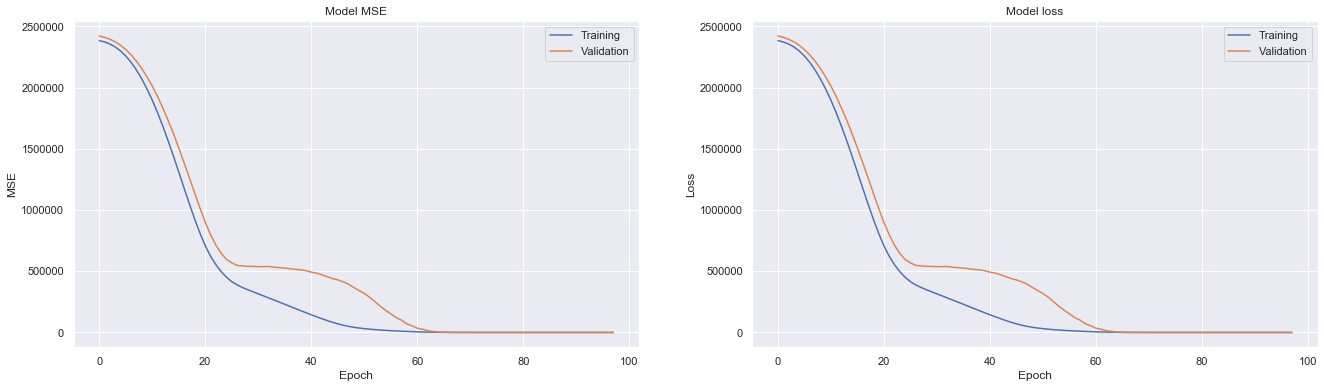

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 14})

# Plot training & validation accuracy values
ax[0].plot(model.history.history['mse'], label = 'Training')
ax[0].plot(model.history.history['val_mse'], label = 'Validation')
ax[0].set_title('Model MSE')
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(model.history.history['loss'], label = 'Training')
ax[1].plot(model.history.history['val_loss'], label = 'Validation')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

In [30]:
r2 = r2_score(y_test, y_hat)
n, p = df.shape # sample size, number of explanatory variables
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
adjusted_r2

0.9991236825129679

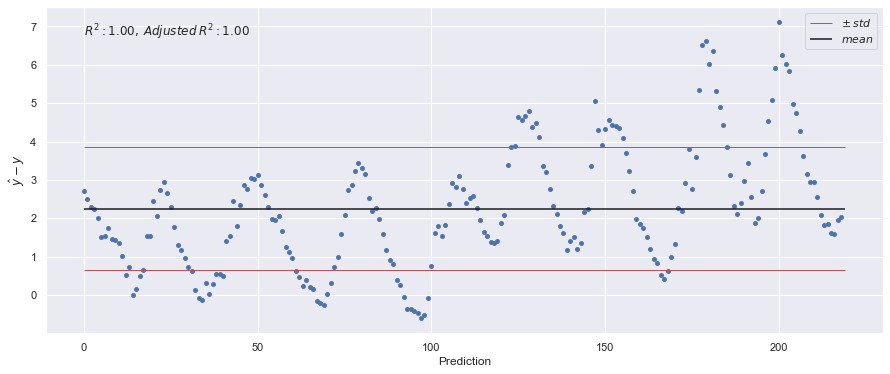

In [31]:
difference = y_hat.flatten() - y_test.values
# difference
d_mean = difference.mean()
d_std = difference.std()
n_pred = len(y_hat)
plt.figure(figsize = (15, 6))
plt.scatter(range(n_pred), difference, s = 15)
plt.hlines(d_mean + d_std, 0, n_pred, 'r', lw = 1, label = '$\pm \: std$')
plt.hlines(d_mean, 0, n_pred, label = '$mean$')
plt.hlines(d_mean - d_std, 0, n_pred, 'r', lw = 1)
plt.xlabel('Prediction')
plt.ylabel('$\hat y - y$')
plt.legend()
plt.text(0, difference.max() * 0.95,
         '$R^2: %.2f, \: Adjusted \: R^2: %.2f$' % (r2, adjusted_r2),
         fontsize = 12)
plt.show()

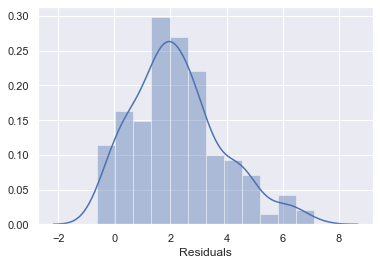

In [32]:
ax = sns.distplot(difference)
ax.set(xlabel='Residuals')
plt.show()

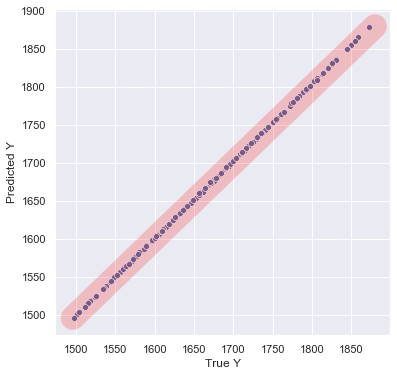

In [33]:
line_x_y = [math.floor(min(y_test.min(),y_hat.min())), math.ceil(max(y_test.max(),y_hat.max()))]
_ = plt.figure(figsize = (6, 6))
_ = plt.plot(line_x_y, line_x_y, linewidth=24, alpha=0.2, color='red')
_ = sns.scatterplot(y_test, y_hat)
_ = plt.ylabel('Predicted Y')
_ = plt.xlabel('True Y')
plt.show()

In [34]:
r2_score(y_test, y_hat)

0.9991276876203127

In [35]:
def get_relative_accuracy(y_test, y_hat, tolerance_percentage):
    it = np.nditer(y_test, flags=['f_index'])
    non_error_count = 0
    
    while not it.finished:
        upper_limit = it[0] * (1 + tolerance_percentage / 100)
        lower_limit = it[0] - (upper_limit - it[0])
        non_error_count += 1 if y_hat[it.index] < upper_limit and y_hat[it.index] > lower_limit else 0
        it.iternext()
        
    return non_error_count / y_test.size

In [36]:
error_tolerance_percentage = 2.5

In [37]:
get_relative_accuracy(y_test, y_hat, error_tolerance_percentage)

1.0